## Import Libraries 

In [1]:
import pandas as pd                               #Library for manipulating the data (using tables)
import numpy as np                                #Library for working with vectors and matrices 
import tensorflow as tf                           #Library for numerical computation
from tensorflow.keras.models import Sequential    #To create the sequential layer
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D,Dropout  #To create the model
from tensorflow.keras.optimizers import Adam      #Adam optimizer
from keras.preprocessing import image             #used for image classification
from keras.preprocessing.image import ImageDataGenerator  #used to expand the training dataset by creating more data from the data set with small variations in scale, rotation, skewness, etc
import matplotlib.pyplot as plt                   #library to plot graphs


# OpenCV Dependencies
from keras.models import load_model              # for loading a pretrained model
from time import sleep
from keras.preprocessing.image import img_to_array  # converts images to an array of floats
import cv2                                          # The OpenCV Library for computer vision


# Data Preprocessing

In [2]:
batch_size = 8
epochs = 30
directory = '../input/siwesfacemaskdatacopy/data'

### Getting Datasets

In [3]:
train_datagen = ImageDataGenerator(validation_split=0.2,        # Splits the data into training (80%) and validation (20%)
                                   rescale = 1./255,            # Multiply the colors by a number between 0-1 to process data faster
                                   rotation_range=40,           #rotate the images by this degrees
                                   width_shift_range=0.2,     
                                   height_shift_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')        #add new pixels when the image is rotated or shifted

train_generator = train_datagen.flow_from_directory(
                                directory,
                                target_size = (70, 70),
                                batch_size = batch_size,
                                color_mode="rgb",               # for coloured images
                                class_mode = 'binary',
                                seed=2020,                      # to make the result reproducible
                                subset = 'training')            # Specify this is training set

validation_generator = train_datagen.flow_from_directory(
                                directory,
                                target_size = (70, 70),
                                batch_size = batch_size,
                                color_mode="rgb",               # for coloured images
                                class_mode = 'binary',
                                subset = 'validation')  

Found 8011 images belonging to 2 classes.
Found 2002 images belonging to 2 classes.


### Some Images from the dataset

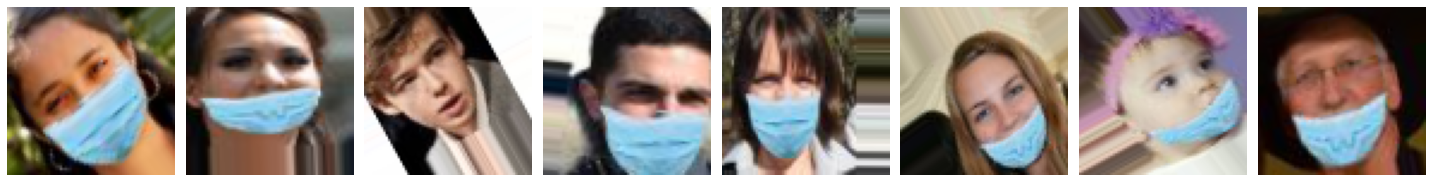

In [4]:
imgs, labels = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, batch_size, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)

### **2. Build and train the CNN**

Sequencial is a list of the layers of the model we want to create. Here it consists of

*   Conv2D Layer
> * **The filter** parameter means the number of this layer's output filters 
> *   **The kernal_size** parameter is commonly used 3*3
> *   **The activation** parameter refers to the type of activation function
> *   **The padding** parameter is enabled to zero-padding
> *   **The input_shape** parameter has pixel high and pixel wide and have the 3 color channels: RGB

*   MaxPool2D Layer
> To pool and reduce the dimensionlaity of the data
*   Flatten Layer
> * flatten is used to flatten the input to a 1D vector then passed to dense

*   Dense Layer (The output layer)
> * **The units** parameter means that it has 2 nodes one for with and one for without because we want a binary output 
> *   **The activation** parameter we use the softmax activation function on our output so that the output for each sample is a probability distribution over the outputs of with and without mask

In [5]:
model = Sequential([
                    Conv2D(filters=32, kernel_size=(3,3),activation='relu',padding='same',input_shape=(70,70,3)),
                    MaxPool2D(pool_size=(2,2), strides=2),
                    Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding= 'same'),
                    MaxPool2D(pool_size=(2,2), strides =2),
                    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding= 'same'),
                    MaxPool2D(pool_size=(2,2), strides =2),
                    Flatten(),
                    Dense(units=64, activation= 'relu'),
                    #means the output is 0,1 (the labels) and the P(c=0) +P(c=1) = 1 
                    Dense(units=1, activation='sigmoid'), 

])

#### Model Summary

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 70, 70, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 35, 35, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0

Compile the model using the **Adam** optimizer with **learning rate** of `0.0001`, a **loss** of `binary_crossentropy`, and we'll look at `accuracy` as our performance **metric**.


In [7]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

### Train Model

In [8]:
history = model.fit(train_generator ,epochs = epochs,validation_data= validation_generator)

Epoch 1/30
1002/1002 [==============================] - 50s 44ms/step - loss: 0.5230 - accuracy: 0.7122 - val_loss: 0.4025 - val_accuracy: 0.8207
Epoch 2/30
1002/1002 [==============================] - 24s 24ms/step - loss: 0.2932 - accuracy: 0.8756 - val_loss: 0.3062 - val_accuracy: 0.8751
Epoch 3/30
1002/1002 [==============================] - 26s 25ms/step - loss: 0.2306 - accuracy: 0.9061 - val_loss: 0.2389 - val_accuracy: 0.9071
Epoch 4/30
1002/1002 [==============================] - 26s 26ms/step - loss: 0.2032 - accuracy: 0.9256 - val_loss: 0.2948 - val_accuracy: 0.8741
Epoch 5/30
1002/1002 [==============================] - 25s 25ms/step - loss: 0.1924 - accuracy: 0.9284 - val_loss: 0.2095 - val_accuracy: 0.9146
Epoch 6/30
1002/1002 [==============================] - 27s 27ms/step - loss: 0.1565 - accuracy: 0.9400 - val_loss: 0.2735 - val_accuracy: 0.8991
Epoch 7/30
1002/1002 [==============================] - 26s 25ms/step - loss: 0.1355 - accuracy: 0.9519 - val_loss: 0.2534 -

### Model Evaluation

#### loss of validation and training 

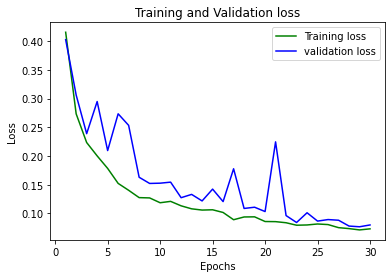

In [9]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochstoplot = range(1,epochs+1)
plt.plot(epochstoplot, loss_train, 'g', label='Training loss')
plt.plot(epochstoplot, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### accuracy of validation and training

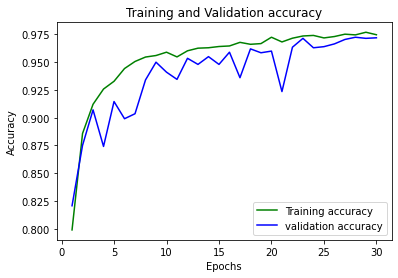

In [10]:
accur_train = history.history['accuracy']
accur_val = history.history['val_accuracy']
plt.plot(epochstoplot, accur_train, 'g', label='Training accuracy')
plt.plot(epochstoplot, accur_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Testing

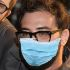



The person is wearing a mask. 



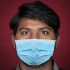



The person is wearing a mask. 



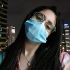



The person is wearing a mask. 



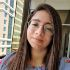



The person is not wearing a mask.



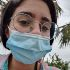



The person is wearing a mask. 



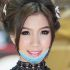



The person is not wearing a mask.



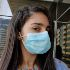



The person is wearing a mask. 



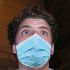



The person is wearing a mask. 



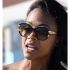



The person is not wearing a mask.



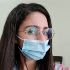



The person is wearing a mask. 



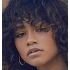



The person is not wearing a mask.



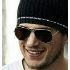



The person is not wearing a mask.



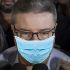



The person is wearing a mask. 



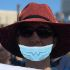



The person is not wearing a mask.



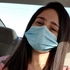



The person is wearing a mask. 



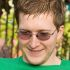



The person is not wearing a mask.



In [11]:
from IPython.display import Image, display
TGREEN =  '\033[1;37;42m'
TRED =    '\033[1;37;41m'

import os

images_dir = "../input/siwesfacemaskdatacopy/test-70x70"
images = os.listdir(images_dir)
   
for img in images:
    img_file = f"{images_dir}/{img}"
    img_pred = image.load_img(img_file, target_size = (70, 70))
    img_pred = image.img_to_array(img_pred)
    img_pred = np.expand_dims(img_pred, axis = 0)

    prediction = model.predict(img_pred)
    display(Image(img_file, width= 150, height=150))
    print("\n")
    if(int(prediction[0][0]) == 0):
        print(TGREEN + "The person is wearing a mask. \n")
    else:
        print(TRED + "The person is not wearing a mask.\n")

### Saving Model

In [15]:
# model.save("mask_checker.h5")
# Save model to json

AttributeError: 'Sequential' object has no attribute 'save_to_json'

## Setup Camera

In [14]:
face_classifier=cv2.CascadeClassifier('../input/siwesfacemaskdatacopy/haarcascade_frontalface_default.xml')
classifier = load_model('./mask_checker.h5')

class_labels=['The person is wearing a mask','The person is not wearing a mask']

cap=cv2.VideoCapture(0)

while True:
    ret,frame=cap.read()
    labels=[]
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=face_classifier.detectMultiScale(gray,1.3,5)

    for (x,y,w,h) in faces:
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        roi_gray=gray[y:y+h,x:x+w]
        roi_gray=cv2.resize(roi_gray,(70,70),interpolation=cv2.INTER_AREA)

        if np.sum([roi_gray])!=0:
            roi=roi_gray.astype('float')/255.0
            roi=img_to_array(roi)
            roi=np.expand_dims(roi,axis=0)

            preds=classifier.predict(roi)[0]
            label=class_labels[preds.argmax()]
            label_position=(x,y)
            cv2.putText(frame,label,label_position,cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
        else:
            cv2.putText(frame,'No Face Found',(20,20),cv2.FONT_HERSHEY_SIMPLEX,2,(0,255,0),3)
    
    cv2.imshow('Mask Checker',frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


error: OpenCV(4.5.2) /tmp/pip-req-build-gvmai4nm/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'
